<a href="https://colab.research.google.com/github/joaochenriques/GeneratorCalib/blob/main/GenFilterPaper_PP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
CASES = {
    0: ( 'T00', '17VPMsByFk7y7hvfCulCVsXU9NFCYm80m' ),
    1: ( 'T01', '1ntRq9wLbatJs7RiALXIoL55ou_dHjGpm' ),
}

CASE = CASES[1]
CASE

('T01', '1ntRq9wLbatJs7RiALXIoL55ou_dHjGpm')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as mpl
import numpy as np
import scipy.io as sio
import h5py

In [4]:
# If running python on Windows operating system, copy the file:
# https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py
# to the working folder before running the notebook

import pathlib
if not pathlib.Path("mpl_utils.py").exists():
  !curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py 

import mpl_utils as mut
mut.config_plots()

%config InlineBackend.figure_formats = ['svg']
mpl.rcParams["figure.figsize"] = (6,4.5)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3483  100  3483    0     0  11806      0 --:--:-- --:--:-- --:--:-- 11846


In [5]:
!pip install gdown &> /dev/null
import gdown

In [6]:
def filters_sym_6th( pnts_seq ):

  b_lst = []
  for Npts in pnts_seq:
    b = np.zeros( Npts )

    float_Npts = float( Npts )
    hpts = Npts / 2

    if Npts % 2 == 0:
      print( ' Number of points should be an odd ', Npts )
      exit(1)

    CONST6_0 = (   1225.E0*float_Npts**6 -  57575.E0*float_Npts**4 +  \
                 605395.E0*float_Npts**2 - 952245.E0 ) / 64.E0
    CONST6_2 = ( -11025.E0*float_Npts**4 + 330750.E0*float_Npts**2
               -1507485.E0 ) / 16.E0
    CONST6_4 = (  24255.E0*float_Npts**2 - 347655.E0 ) / 4.E0
    CONST6_6 = -15015.E0
    Denomi_6 =  4.E0 * float_Npts * ( float_Npts**6 - 56.E0*float_Npts**4
            + 784.E0*float_Npts**2 - 2304.E0 )

    mid_Coef = np.array( [ CONST6_0 / Denomi_6 ] )
    pl = np.array( [CONST6_6, 0.0, CONST6_4, 0.0, CONST6_2, 0.0, CONST6_0] )

    float_I = np.arange( 1.0, hpts + 0.1, 1.0 )

    Coefs = np.polyval( pl, float_I ) / Denomi_6

    lst = np.concatenate( ( Coefs[::-1], mid_Coef, Coefs ) )
    b_lst.append( lst )
    
  return b_lst

In [7]:
TEST_CASE_NAME = CASE[0]
tests_filename = CASE[0]
gdown_filename = CASE[1]

dat_filename = TEST_CASE_NAME + '.mat'
dat_filename

'T01.mat'

In [8]:
if not pathlib.Path( dat_filename ).exists():
    gdown.download( id=gdown_filename, output=dat_filename, quiet=False )

Downloading...
From: https://drive.google.com/uc?id=1ntRq9wLbatJs7RiALXIoL55ou_dHjGpm
To: /content/T01.mat
100%|██████████| 2.11G/2.11G [00:20<00:00, 102MB/s]


In [9]:
hf = h5py.File( dat_filename, 'r' )
TData = hf['TData']
TData.keys()

<KeysViewHDF5 ['Time', 'i1out', 'i3out', 'u1u2out', 'u2u3out']>

In [10]:
u1u2out = np.array( TData['u1u2out'] )[0] * 114.7821
u2u3out = np.array( TData['u2u3out'] )[0] * 117.3088

i1out = np.array( TData['i1out'] )[0] * 48.852
i3out = np.array( TData['i3out'] )[0] * 50.020

len( i3out )

78125000

In [11]:
u_HF_seq = np.array( [1063, 1015,  967,  919,  871,  811] )
u_LF_seq = np.array( [17419, 16603, 15787, 14971, 14155, 13315] )

HF_coeffs = filters_sym_6th( u_HF_seq )
LF_coeffs = filters_sym_6th( u_LF_seq )

len( HF_coeffs )

6

## Reduce the number of points to speed-up filtering

In [12]:
Time = np.array( TData['Time'] )[0]
fs = int( 1.0 /( Time[1]-Time[0] ) )

N1 = 50 * fs 

Time = Time[0:N1]
t0 = Time[0]
Time -= t0

N1, fs

(3125000, 62500)

In [13]:
u1u2out = u1u2out[0:N1]
u2u3out = u2u3out[0:N1]

i1out = i1out[0:N1]
i3out = i3out[0:N1]

In [14]:
def FilterSignal( coeffs, time, unf_signal ):

  NS = unf_signal.shape[0]
  NC = coeffs.shape[0]

  assert( NC % 2 > 0 ) # assert that is a centred filter (odd)

  flt_signal = np.convolve( unf_signal, coeffs, 'valid')
  hNC = int( NC / 2 )
  flt_time = time[ hNC: NS-hNC ]

  assert( flt_time.shape[0] == flt_signal.shape[0] )

  cut_time = time[ hNC: NS-hNC ]
  cut_unf_signal = unf_signal[ hNC: NS-hNC ]
  
  return cut_time, cut_unf_signal, flt_time, flt_signal

## filtering u1u2outGen

In [15]:
flt_time = Time.copy()
flt_u1u2out = u1u2out.copy()

for coeffs in HF_coeffs:
    print( f"LP filter len = {len( coeffs )}" )
    _, _, flt_time, flt_u1u2out = FilterSignal( coeffs, flt_time, flt_u1u2out )

# for coeffs in LF_coeffs:
#     print( f"HP filter len = {len( coeffs )}" )
#     _, cut_unf_u1u2out, flt_time, flt2_u1u2out = FilterSignal( coeffs, flt_time, flt_u1u2out )
#     flt_u1u2out = cut_unf_u1u2out - flt2_u1u2out

flt_time -= t0

LP filter len = 1063
LP filter len = 1015
LP filter len = 967
LP filter len = 919
LP filter len = 871
LP filter len = 811


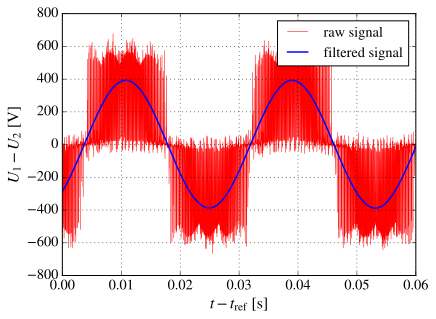

In [27]:
n0 = int(  1 * fs )
n1 = int( 40 * fs )
n2 = int( 42 * fs )

tt0 = Time[n1]

mpl.plot( Time[n1:n2] - tt0, u1u2out[n1:n2], '-r', lw=0.5, label='raw signal' )
mpl.plot( flt_time[n1-n0:n2-n0] - tt0, flt_u1u2out[n1-n0:n2-n0], '-b', lw=1.5, label='filtered signal' )

mpl.legend()
mpl.grid()
mpl.xlabel( "$t-t_\mathrm{ref}$ [s]")
mpl.ylabel( "$U_1 - U_2$ [V]" )
mpl.xlim( Time[n1] - tt0, Time[n1] - tt0 + 0.06 )
# mpl.ylim( -6, 6 )
mpl.savefig('FIGXX_u1u2_TimeSeries.pdf', bbox_inches='tight');

## filtering i1out

In [17]:
flt_time = Time.copy()
flt_i1out = i1out.copy()

for coeffs in HF_coeffs:
    print( f"LP filter len = {len( coeffs )}" )
    _, _, flt_time, flt_i1out = FilterSignal( coeffs, flt_time, flt_i1out )

# for coeffs in LF_coeffs:
#     print( f"HP filter len = {len( coeffs )}" )
#     _, cut_unf_i1out, flt_time, flt2_i1out = FilterSignal( coeffs, flt_time, flt_i1out )
#     flt_i1out = cut_unf_i1out - flt2_i1out

flt_time -= t0

LP filter len = 1063
LP filter len = 1015
LP filter len = 967
LP filter len = 919
LP filter len = 871
LP filter len = 811


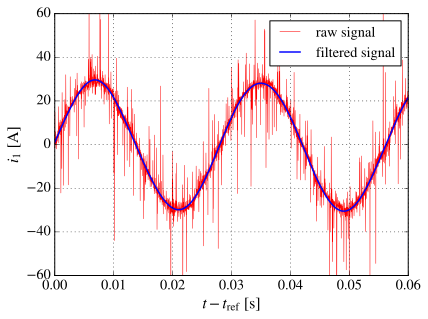

In [28]:
n0 = int(  1 * fs )
n1 = int( 40 * fs )
n2 = int( 42 * fs )

tt0 = Time[n1]

mpl.plot( Time[n1:n2] - tt0, i1out[n1:n2], '-r', lw=0.5, label='raw signal' )
mpl.plot( flt_time[n1-n0:n2-n0] - tt0, flt_i1out[n1-n0:n2-n0], '-b', lw=1.5, label='filtered signal' )

mpl.legend()
mpl.grid()
mpl.xlabel( "$t-t_\mathrm{ref}$ [s]")
mpl.ylabel( "$i_1$ [A]" )
mpl.xlim( Time[n1] - tt0, Time[n1] - tt0 + 0.06 )
mpl.ylim( -60, 60 )
mpl.savefig('FIGXX_i1_TimeSeries.pdf', bbox_inches='tight');